# Setup and Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


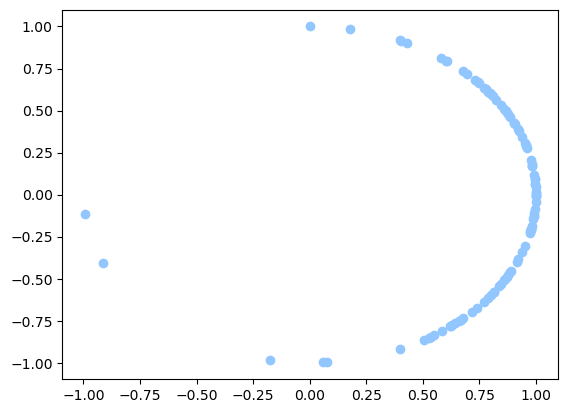

In [3]:
import torch
import matplotlib.pyplot as plt
from notebook_setup import device 
# set any device you want:
device = torch.device('cuda:0')
from data.distributions import VonMisesEuclidean
%load_ext autoreload
%autoreload 2

torch.manual_seed(0)
data = VonMisesEuclidean().sample((100,))
plt.scatter(*data.T)

# Modelling

This uses a simple MLP-based network for diffusion, where here N=2:
1. The network's `forward` method takes two inputs (both batched): an N-d data input and a scalar timestep. 
2. It then concatenatates these (into an (N+1)-d vector) and passes them through an MLP that produces an N-d result.

Set up model

In [4]:
from models.diffusions.sdes import VpSde
from models.diffusions.networks import SimpleDiffusionMLP


network = SimpleDiffusionMLP(2, hidden_sizes=(512, 512)).to(device)
sde = VpSde(network)  # This class contains the logic for the actual SDE

Set up training

In [9]:
%autoreload 2
from functools import partial
from torch import optim
from models.diffusions.training import LightningDiffusion
from models.training import LightweightTrainer

model = LightningDiffusion(  # This class contains training logic
    sde=sde,
    optim_partial=partial(optim.Adam, lr=1e-3),  # A partial to define the optimizer
)

trainer = LightweightTrainer(
    max_epochs=20000,
    device=device,
)
loader = torch.utils.data.DataLoader(data, batch_size=100)

trainer.fit(model=model, train_dataloader=loader, ckpt_path='outputs/notebooks/von_mesis')

/home/hamid/miniconda3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training epochs [Batch 1/1]: 100%|██████████| 20000/20000 [00:50<00:00, 396.65it/s, loss=0.211] 


# Evaluation

What do the model's samples look like?

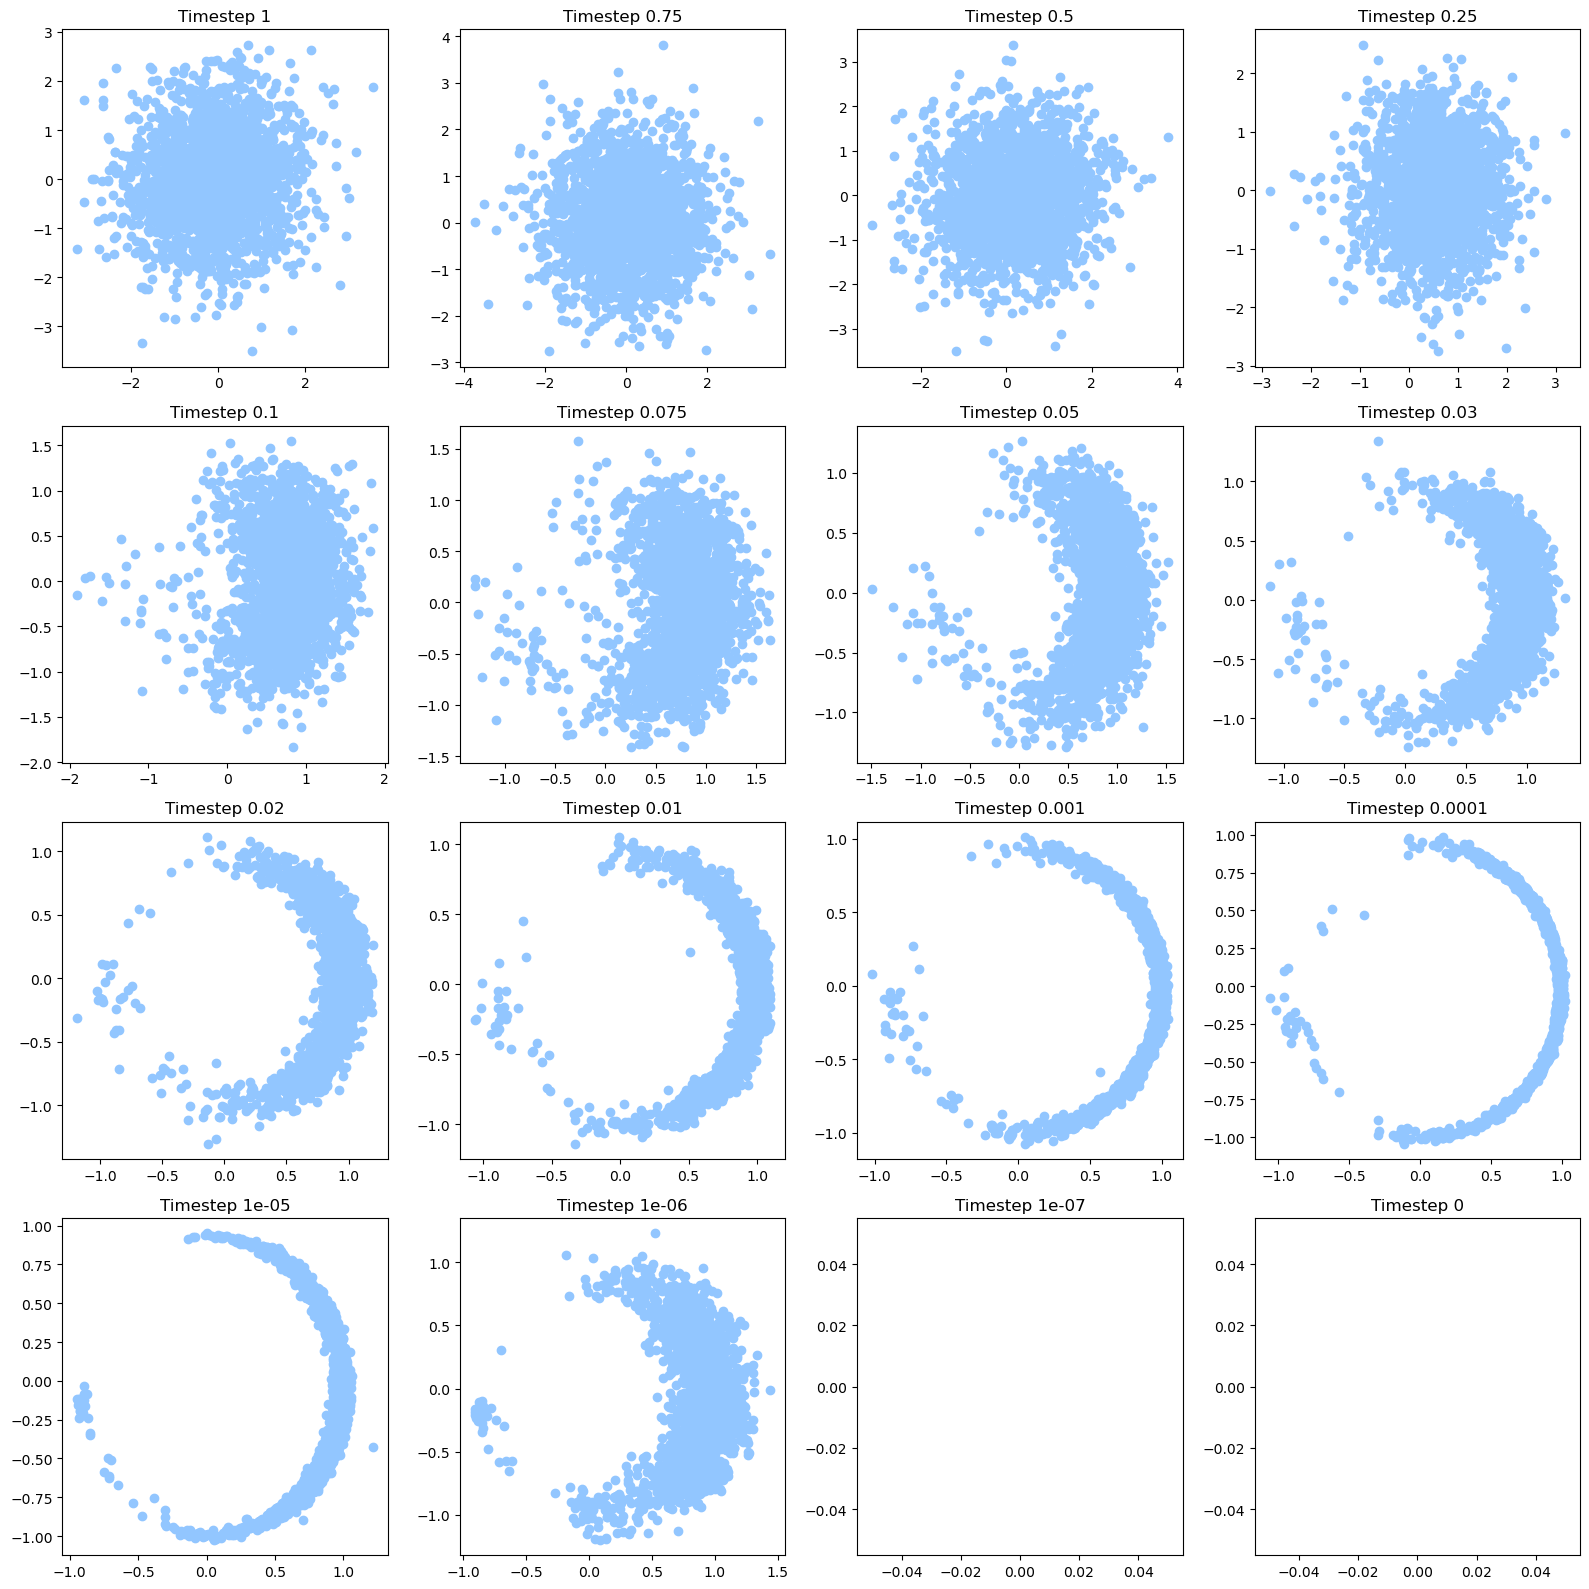

In [10]:
timesteps = (
    1,
    0.75,
    0.5,
    0.25,
    1e-1,
    7.5e-2,
    5e-2,
    3e-2,
    2e-2,
    1e-2,
    1e-3,
    1e-4,
    1e-5,
    1e-6,
    1e-7,
    0,
)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
assert len(timesteps) == len(axes.flatten())

noise = torch.randn(2000, 2).to(device)
sde.to(device)

for ax, timestep in zip(axes.flatten(), timesteps):  # Generate 1k points and plot them
    gen_sample = sde.solve_reverse_sde(noise, t_start=1.0, t_end=timestep)
    ax.scatter(*gen_sample.cpu().T)
    ax.set_title(f"Timestep {timestep}")

fig.tight_layout()

Let's check the same with the ODE

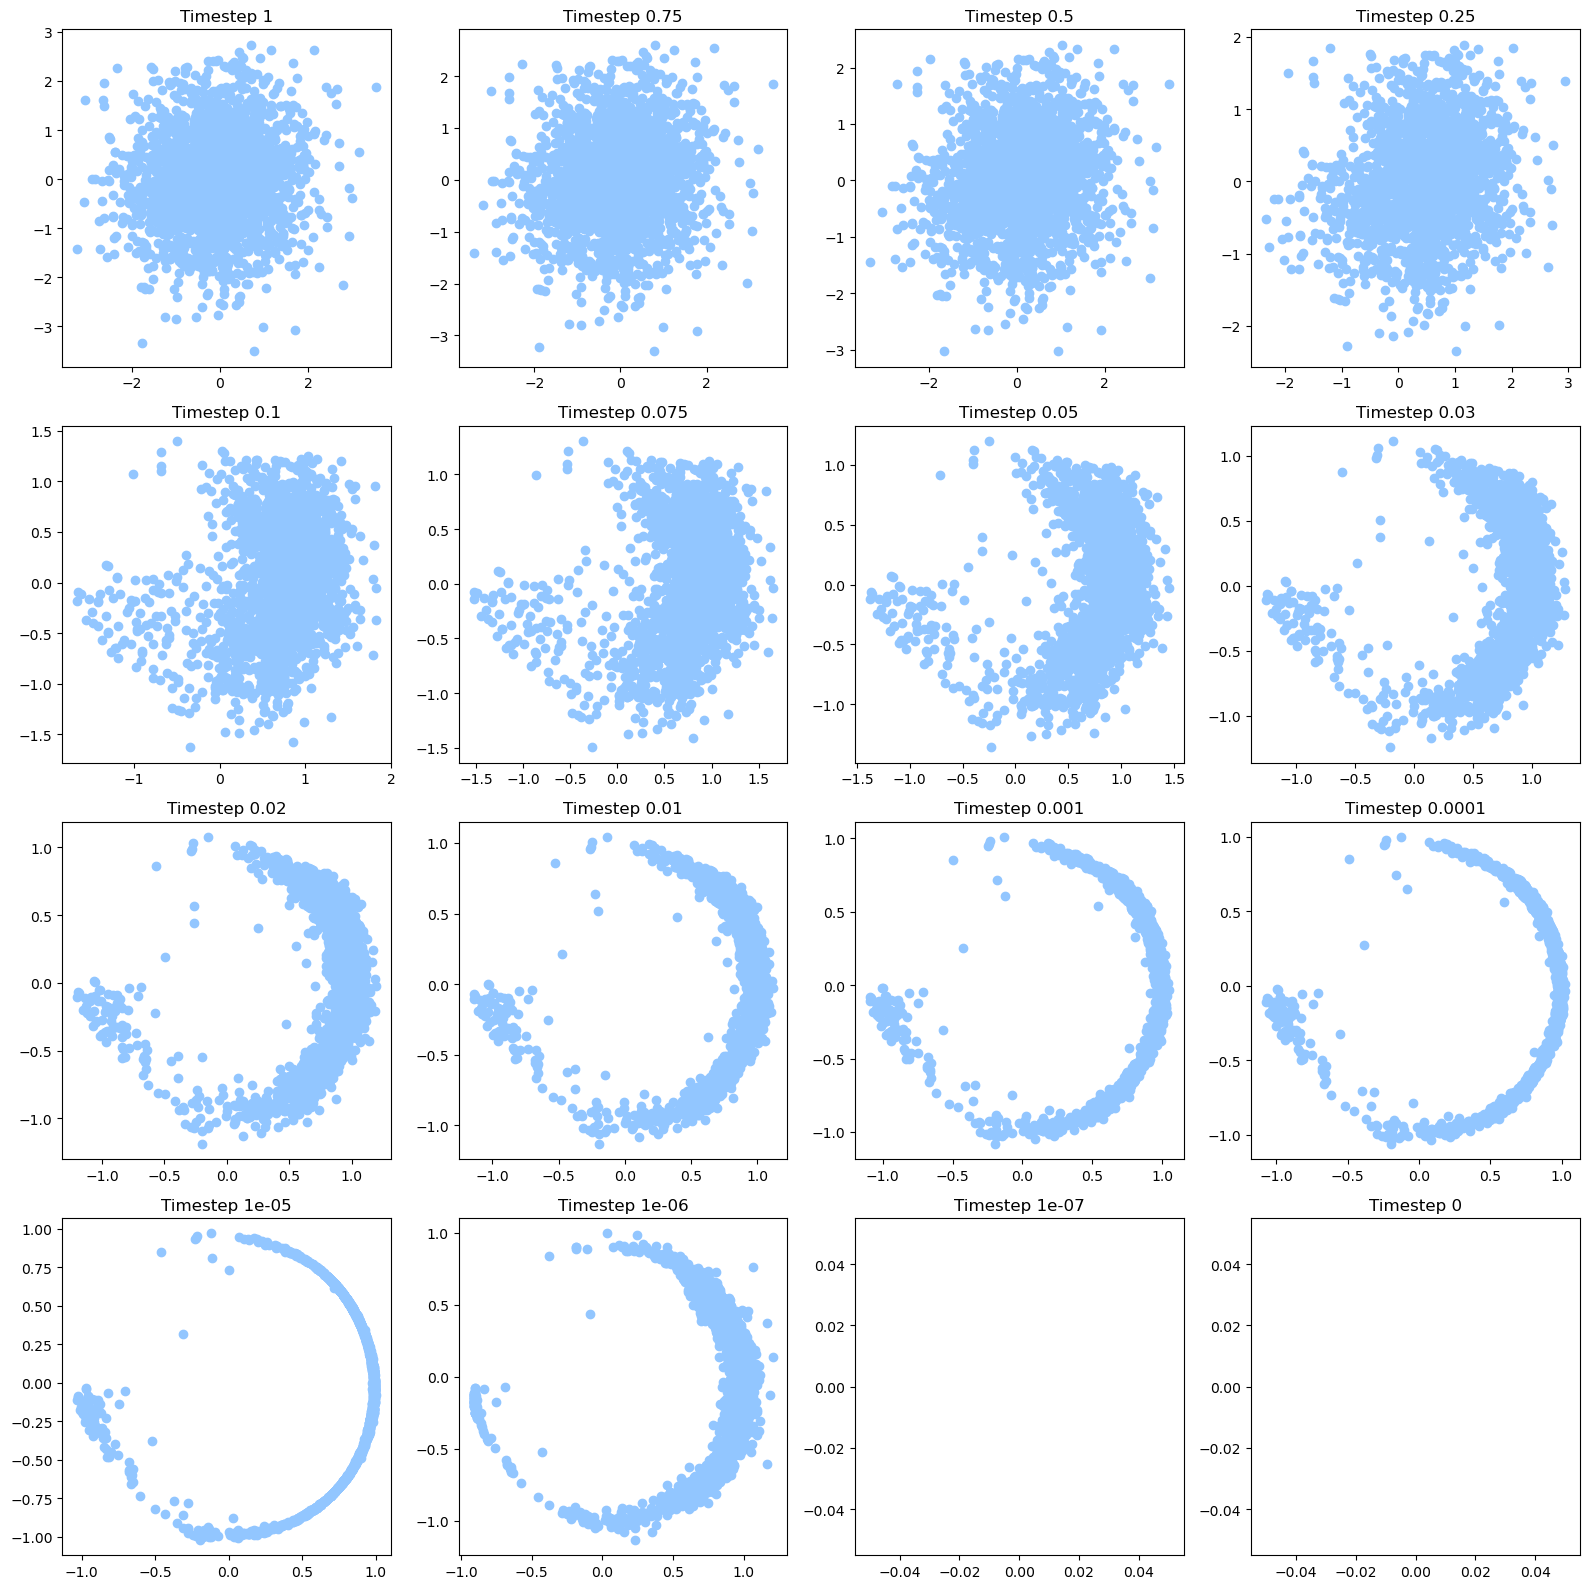

In [11]:
timesteps = (
    1,
    0.75,
    0.5,
    0.25,
    1e-1,
    7.5e-2,
    5e-2,
    3e-2,
    2e-2,
    1e-2,
    1e-3,
    1e-4,
    1e-5,
    1e-6,
    1e-7,
    0,
)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
assert len(timesteps) == len(axes.flatten())

for ax, timestep in zip(axes.flatten(), timesteps):  # Generate 1k points and plot them
    gen_sample = sde.solve_reverse_ode(noise, t_start=1.0, t_end=timestep)
    ax.scatter(*gen_sample.cpu().T)
    ax.set_title(f"Timestep {timestep}")

fig.tight_layout()

Check network norms for each timestep

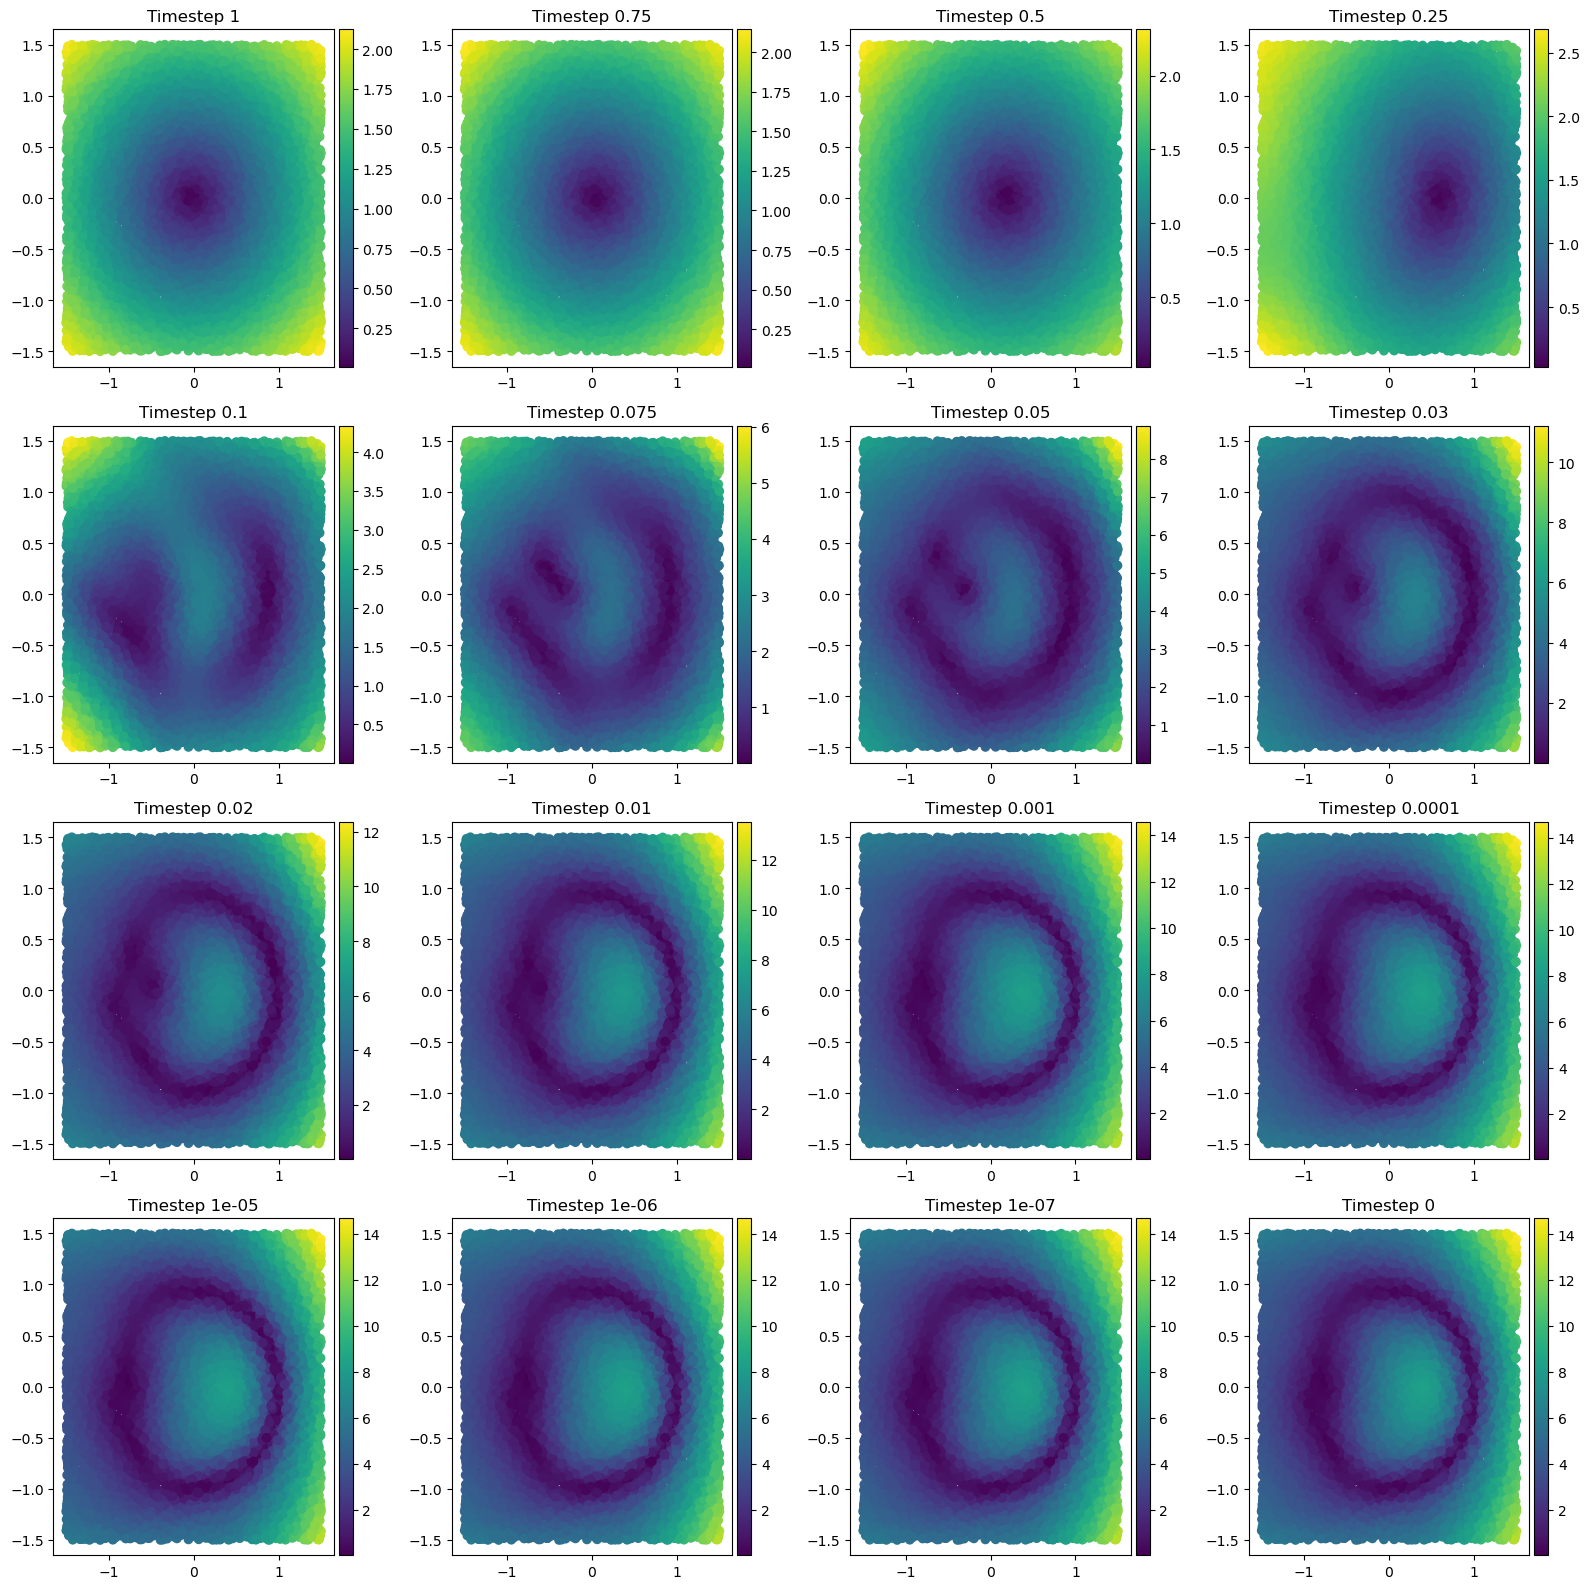

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

test_points = torch.rand(10000, 2) * 3 - 1.5
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
assert len(timesteps) == len(axes.flatten())

for ax, timestep in zip(axes.flatten(), timesteps):
    # Core logic in loop; run test points through the network and compute the norms of its outputs
    with torch.no_grad():
        test_timesteps = torch.full((test_points.shape[0],), timestep)
        timestep_norms = network(
            test_points.to(device), t=test_timesteps.to(device)
        ).norm(dim=1)

    # Graph the norms
    s = ax.scatter(*test_points.T, c=timestep_norms.cpu())
    ax.set_title(f"Timestep {timestep}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(s, cax=cax, orientation="vertical")


fig.tight_layout()

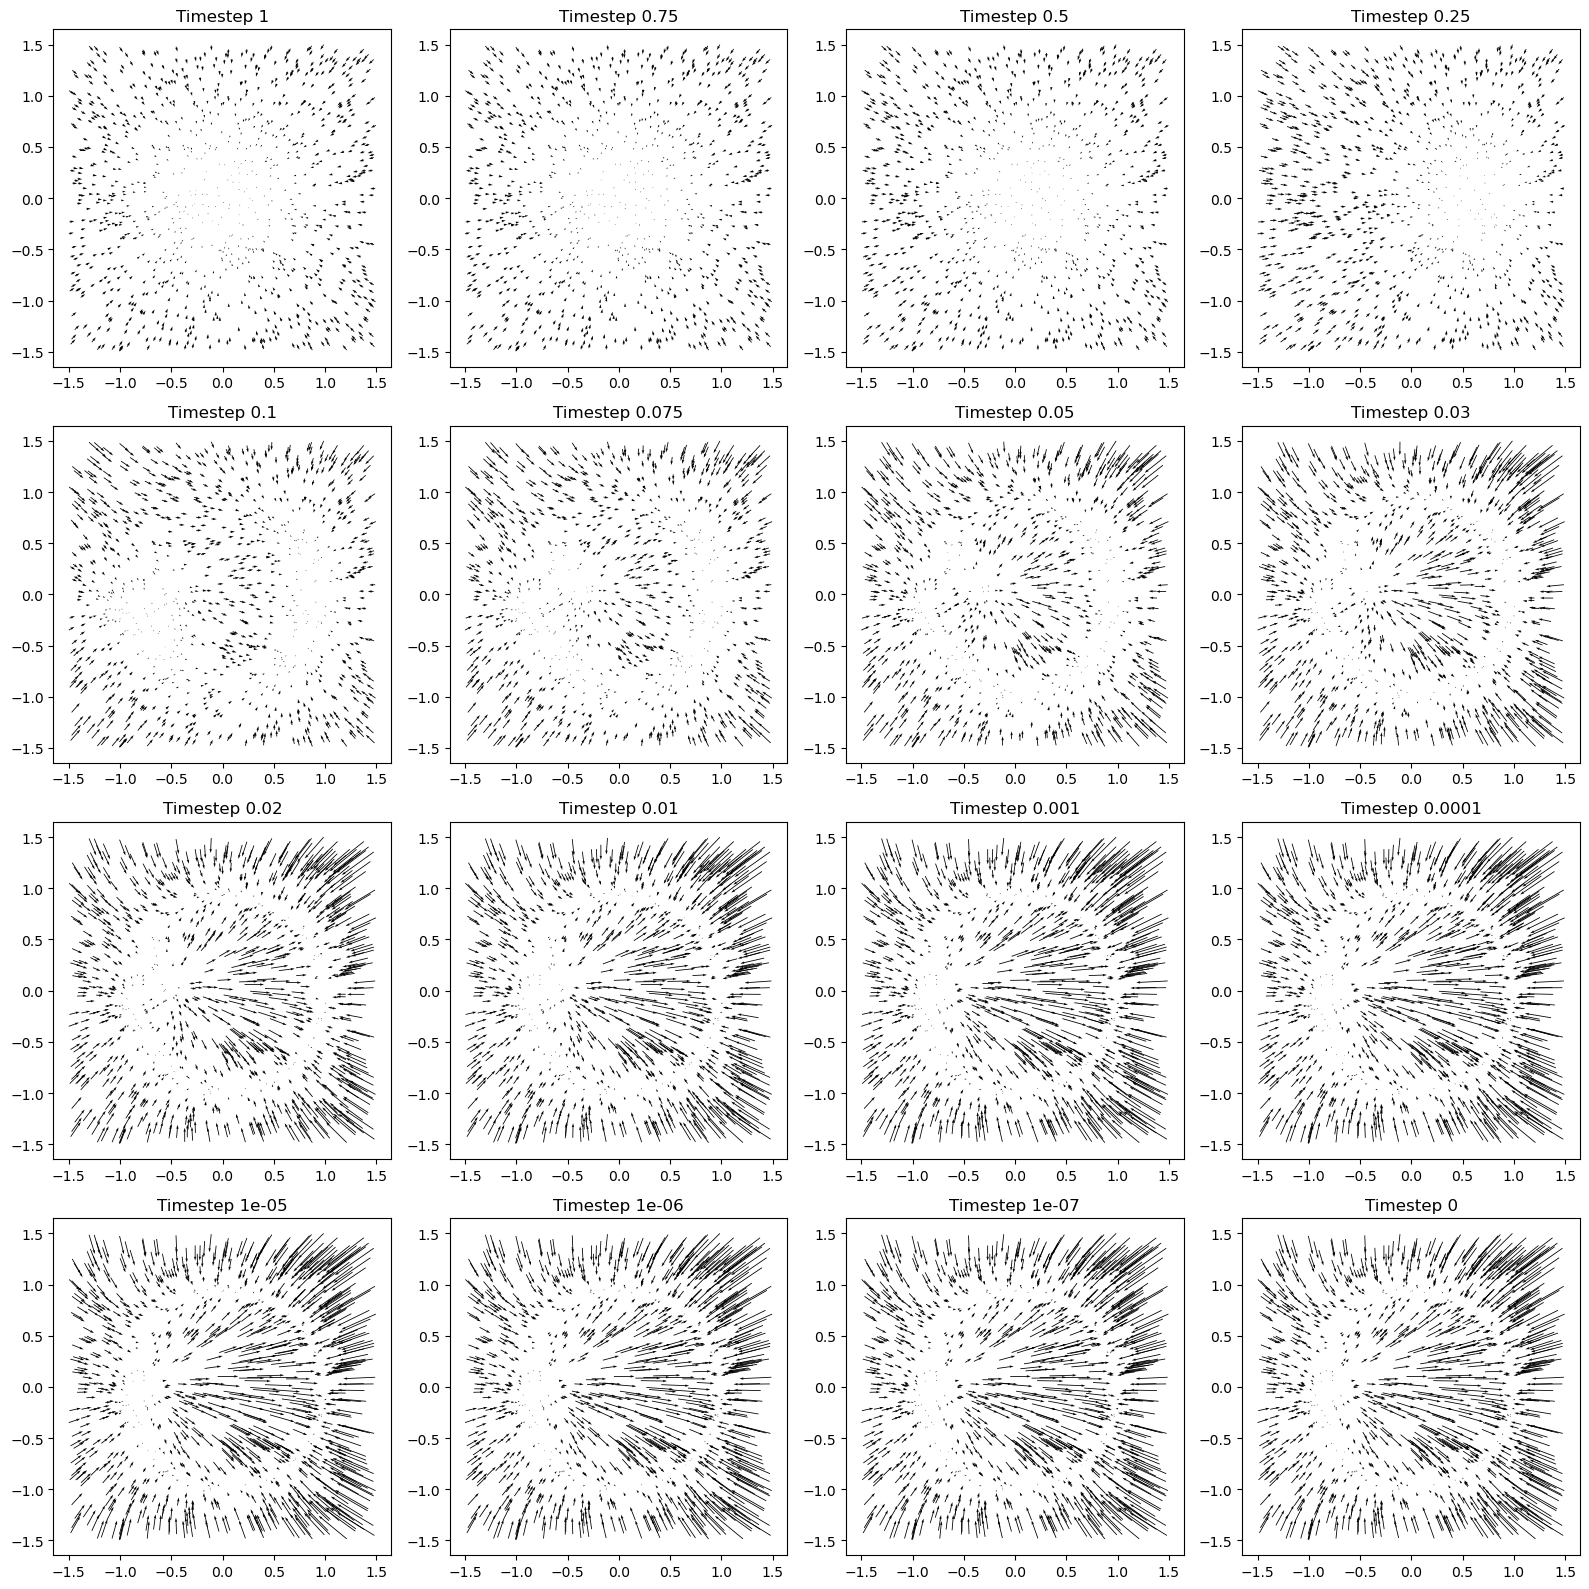

In [13]:
test_points = torch.rand(1000, 2) * 3 - 1.5
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for ax, timestep in zip(axes.flatten(), timesteps):
    # Core logic in loop; run test points through the network and compute the norms of its outputs
    with torch.no_grad():
        test_timesteps = torch.full((test_points.shape[0],), timestep)
        timestep_outputs = network(
            test_points.to(device), t=test_timesteps.to(device)
        ).cpu()

    # Graph the norms
    s = ax.quiver(*torch.cat((test_points.T, timestep_outputs.T)), scale=100)
    ax.set_title(f"Timestep {timestep}")


fig.tight_layout()